# TASK 5

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility function

In [2]:
%tensorflow_version 2.x
import os
import itertools
import csv
import numpy as np
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import random as rn
from numpy import dstack
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from keras.applications.inception_v3 import preprocess_input 
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task5_1') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 64


# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### Loading training and test set

In [3]:
# Loading test set
def load_train():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels

### Plotting the confusion matrix

In [4]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

### Plotting the ROC curve

In [5]:
def plot_roc_curve(model, test_im, test_labels):
    probs = model.predict(test_im)
    fpr, tpr, threshold = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Plotting accuracy and loss trends

In [6]:
def performance_plot(history, model):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Setting the seed

In [7]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

## Dataset creation

In [8]:
train_img, train_lab = load_train()
test_img, test_lab = load_test()


In [9]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') * 0.003891051

# mass
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 2] = 0
# calcification
abnormality_labels[abnormality_labels == 3] = 1
abnormality_labels[abnormality_labels == 4] = 1

# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)

# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') * 0.003891051

# mass
test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 0
# calcification
test_labels[test_labels == 3] = 1
test_labels[test_labels == 4] = 1


## Loading the best models

In [10]:
model1 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_1/model10_best.h5'))
#result = model1.evaluate(test_images, test_labels, batch_size=64)
#print(result)

model2 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_1/model9_best.h5'))
#result = model2.evaluate(test_images, test_labels, batch_size=64)
#print(result)

model3 = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_1/inception3_best.h5'))


### Inception and scratch model preprocessing

In [11]:
def scratch_preprocessing(input):
  return input/255

def inception_preprocess(input):
  return preprocess_input(np.repeat(input, 3, axis=3))


## Ensemble with loaded models

### Logistic Regression

Stacked Train Accuracy: 0.928
Stacked Test Accuracy: 0.899
Specificity :  0.8994413407821229
Sensitivity :  0.8980891719745223


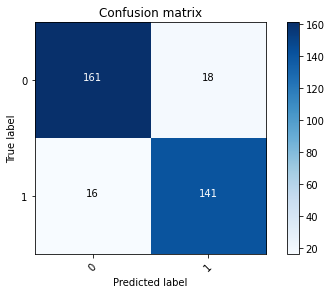

Stacked Valid Accuracy: 0.913
Specificity :  0.9068493150684932
Sensitivity :  0.9178082191780822


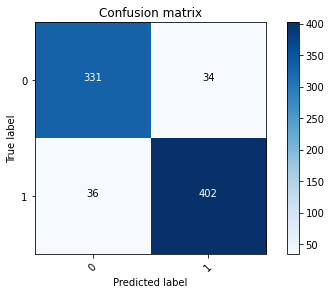

In [ ]:
set_seed()

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model['model'].predict(model['preprocess'](inputX), verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[{'model': model1, 'preprocess': scratch_preprocessing}, 
         {'model': model2, 'preprocess': scratch_preprocessing},
         {'model': model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble, os.path.join(MODEL_PATH, 'logreg_pretrained.h5'))

train_pred = stacked_prediction(members, ensemble, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble on test set
pred = stacked_prediction(members, ensemble, test_images)
acc = accuracy_score(test_labels, np.rint(pred))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Linear SVC

Stacked Train Accuracy: 0.930
Stacked Test Accuracy: 0.902
Specificity :  0.9050279329608939
Sensitivity :  0.8980891719745223


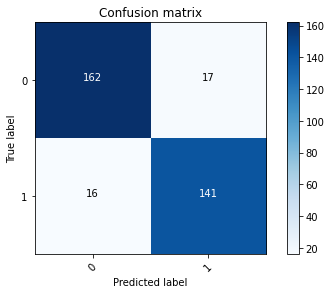

Stacked Valid Accuracy: 0.913
Specificity :  0.9095890410958904
Sensitivity :  0.9155251141552512


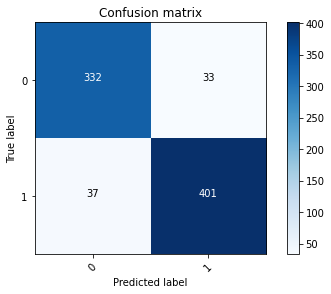

In [ ]:
set_seed()

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LinearSVC()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': model1, 'preprocess': scratch_preprocessing}, 
         {'model': model2, 'preprocess': scratch_preprocessing},
         {'model': model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble2 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble2, os.path.join(MODEL_PATH, 'logreg_pretrained.h5'))

# evaluate model on test set
train_yhat = stacked_prediction(members, ensemble2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble2 on test set
yhat = stacked_prediction(members, ensemble2, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, ensemble2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.931
Stacked Test Accuracy: 0.899
Specificity :  0.9050279329608939
Sensitivity :  0.89171974522293


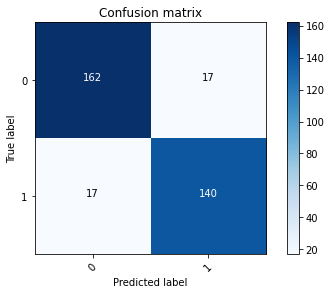

Stacked Valid Accuracy: 0.912
Specificity :  0.9095890410958904
Sensitivity :  0.91324200913242


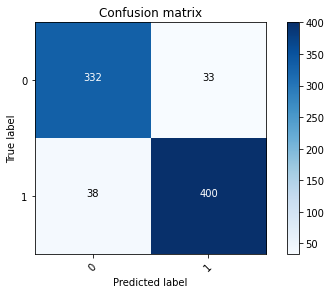

In [ ]:
set_seed()

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = SVC()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': model1, 'preprocess': scratch_preprocessing}, 
         {'model': model2, 'preprocess': scratch_preprocessing},
         {'model': model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble3 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble3, os.path.join(MODEL_PATH, 'lsvc_pretrained.h5'))

train_yhat = stacked_prediction(members, ensemble3, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble3 on test set
yhat = stacked_prediction(members, ensemble3, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, ensemble3, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

## Ensemble with intermediate layers of loaded models

In [12]:
intermediate_layer_model1 = keras.Model(inputs=model1.input,
                                       outputs=model1.get_layer("dense_1").output)
intermediate_layer_model2 = keras.Model(inputs=model2.input,
                                       outputs=model2.get_layer("dense").output)
intermediate_layer_model3 = keras.Model(inputs=model3.input,
                                       outputs=model3.get_layer("dense").output)

intermediate_layer_model1.save(os.path.join(MODEL_PATH, 'model10_pretrained_layers.h5'))
intermediate_layer_model2.save(os.path.join(MODEL_PATH, 'model9_pretrained_layers.h5'))
intermediate_layer_model3.save(os.path.join(MODEL_PATH, 'inception_layers.h5'))

### Dense layer

Epoch 1/50
59/59 [==============================] - 1s 11ms/step - loss: 0.3819 - acc: 0.8168 - val_loss: 0.2229 - val_acc: 0.9103

Epoch 00001: val_loss improved from inf to 0.22295, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_pretrained_best.h5
Epoch 2/50
59/59 [==============================] - 0s 2ms/step - loss: 0.1840 - acc: 0.9299 - val_loss: 0.2192 - val_acc: 0.9103

Epoch 00002: val_loss improved from 0.22295 to 0.21922, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_pretrained_best.h5
Epoch 3/50
59/59 [==============================] - 0s 3ms/step - loss: 0.1955 - acc: 0.9234 - val_loss: 0.2153 - val_acc: 0.9128

Epoch 00003: val_loss improved from 0.21922 to 0.21527, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_pretrained_best.h5
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 0.1828 - acc: 0.923

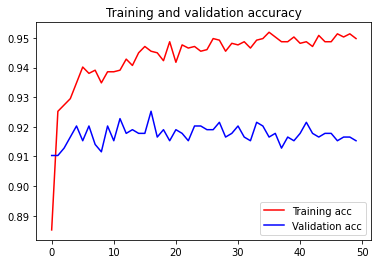

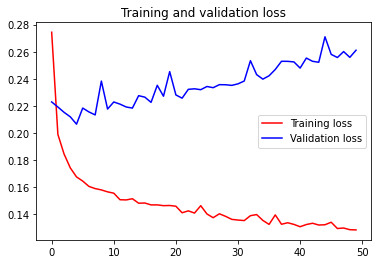

Stacked Train Accuracy: 0.938
Stacked Test Accuracy: 0.908
Specificity :  0.9217877094972067
Sensitivity :  0.89171974522293


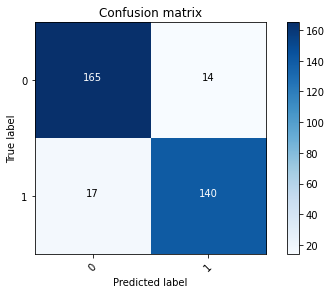

Stacked Valid Accuracy: 0.920
Specificity :  0.9095890410958904
Sensitivity :  0.9292237442922374


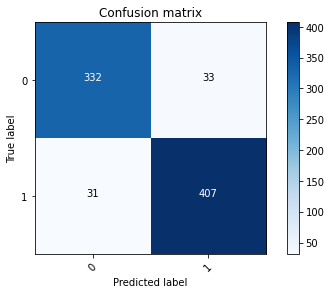

In [13]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if yhat.shape[1] == 64:
          yhat = np.hstack((yhat, yhat, yhat, yhat, yhat, yhat, yhat, yhat))
      elif yhat.shape[1] == 128:
          yhat = np.hstack((yhat, yhat, yhat, yhat))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dense(1, input_dim=1536, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model1_pretrained_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=50, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint])

    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': intermediate_layer_model1, 'preprocess': scratch_preprocessing}, 
         {'model': intermediate_layer_model2, 'preprocess': scratch_preprocessing},
         {'model': intermediate_layer_model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
model1 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model1.save(os.path.join(MODEL_PATH, 'model1_pretrained.h5'))
best_model1 = models.load_model(os.path.join(MODEL_PATH, 'model1_pretrained_best.h5'))

train_yhat = stacked_prediction(members, best_model1, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate model1 on test set
yhat = stacked_prediction(members, best_model1, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, best_model1, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Dense layer and dropout

Epoch 1/50
59/59 [==============================] - 1s 5ms/step - loss: 0.3946 - acc: 0.8203 - val_loss: 0.2284 - val_acc: 0.9103

Epoch 00001: val_loss improved from inf to 0.22839, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_pretrained_best.h5
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 0.1913 - acc: 0.9245 - val_loss: 0.2176 - val_acc: 0.9116

Epoch 00002: val_loss improved from 0.22839 to 0.21759, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_pretrained_best.h5
Epoch 3/50
59/59 [==============================] - 0s 3ms/step - loss: 0.2135 - acc: 0.9184 - val_loss: 0.2131 - val_acc: 0.9178

Epoch 00003: val_loss improved from 0.21759 to 0.21310, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_pretrained_best.h5
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 0.1956 - acc: 0.9200

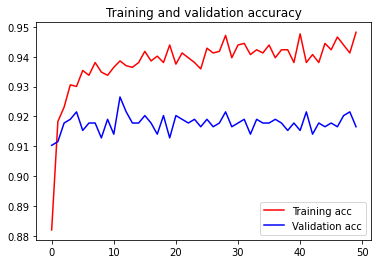

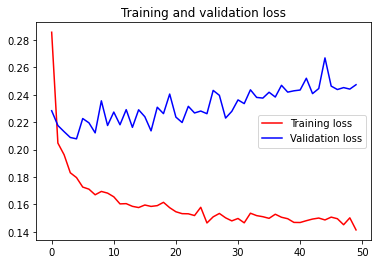

Stacked Train Accuracy: 0.936
Stacked Test Accuracy: 0.908
Specificity :  0.9217877094972067
Sensitivity :  0.89171974522293


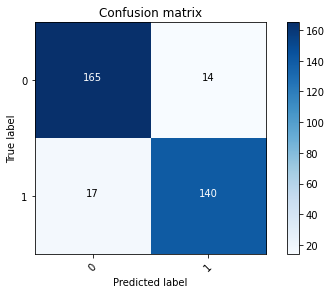

Stacked Valid Accuracy: 0.922
Specificity :  0.9123287671232877
Sensitivity :  0.9292237442922374


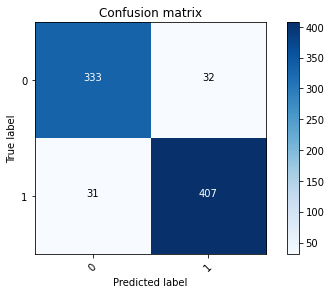

In [18]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if yhat.shape[1] == 64:
          yhat = np.hstack((yhat, yhat, yhat, yhat, yhat, yhat, yhat, yhat))
      elif yhat.shape[1] == 128:
          yhat = np.hstack((yhat, yhat, yhat, yhat))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, input_dim=1536, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model2_pretrained_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=50, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint])

    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': intermediate_layer_model1, 'preprocess': scratch_preprocessing}, 
         {'model': intermediate_layer_model2, 'preprocess': scratch_preprocessing},
         {'model': intermediate_layer_model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
model2 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model2.save(os.path.join(MODEL_PATH, 'model2_pretrained.h5'))
best_model2 = models.load_model(os.path.join(MODEL_PATH, 'model2_pretrained_best.h5'))

train_yhat = stacked_prediction(members, best_model2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate model2 on test set
yhat = stacked_prediction(members, best_model2, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, best_model2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

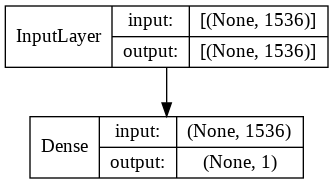

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task5_1/model1_pretrained_best.h5'))
plot_model(model, to_file='5_1_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

### Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacked Train Accuracy: 0.962
Stacked Test Accuracy: 0.893
Specificity :  0.9050279329608939
Sensitivity :  0.8789808917197452


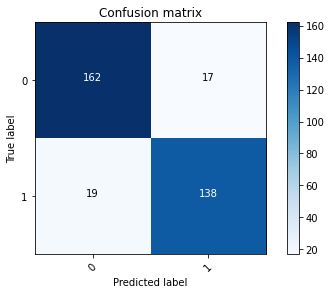

Stacked Valid Accuracy: 0.913
Specificity :  0.9013698630136986
Sensitivity :  0.9223744292237442


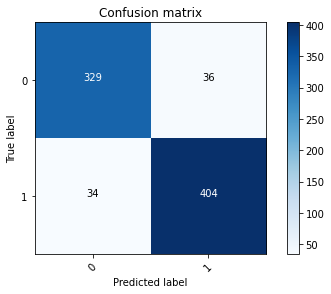

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if yhat.shape[1] == 64:
          yhat = np.hstack((yhat, yhat, yhat, yhat, yhat, yhat, yhat, yhat))
      elif yhat.shape[1] == 128:
          yhat = np.hstack((yhat, yhat, yhat, yhat))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
      # create dataset using ensemble
      stackedX = stacked_dataset(members, inputX)
      # fit standalone model
      model = LogisticRegression(max_iter=500)
      model.fit(stackedX, inputy)
      return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': intermediate_layer_model1, 'preprocess': scratch_preprocessing}, 
         {'model': intermediate_layer_model2, 'preprocess': scratch_preprocessing},
         {'model': intermediate_layer_model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble4 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble4, os.path.join(MODEL_PATH, 'logreg_pretrained_layers.h5'))

train_yhat = stacked_prediction(members, ensemble4, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble4 on test set
yhat = stacked_prediction(members, ensemble4, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, ensemble4, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### LinearSVC

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Stacked Train Accuracy: 0.970
Stacked Test Accuracy: 0.869
Specificity :  0.8547486033519553
Sensitivity :  0.8853503184713376


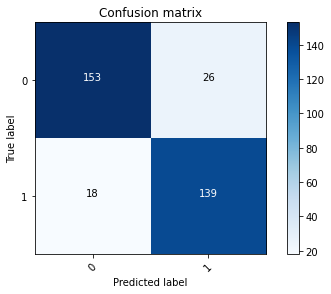

Stacked Valid Accuracy: 0.898
Specificity :  0.873972602739726
Sensitivity :  0.9178082191780822


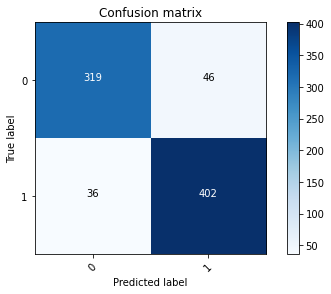

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if yhat.shape[1] == 64:
          yhat = np.hstack((yhat, yhat, yhat, yhat, yhat, yhat, yhat, yhat))
      elif yhat.shape[1] == 128:
          yhat = np.hstack((yhat, yhat, yhat, yhat))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LinearSVC()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': intermediate_layer_model1, 'preprocess': scratch_preprocessing}, 
         {'model': intermediate_layer_model2, 'preprocess': scratch_preprocessing},
         {'model': intermediate_layer_model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble5 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble5, os.path.join(MODEL_PATH, 'lsvc_pretrained_layers.h5'))

train_yhat = stacked_prediction(members, ensemble5, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble5 on test set
yhat = stacked_prediction(members, ensemble5, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, ensemble5, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.944
Stacked Test Accuracy: 0.902
Specificity :  0.9273743016759777
Sensitivity :  0.8726114649681529


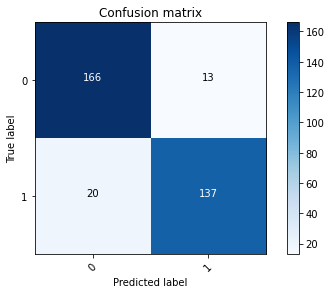

Stacked Valid Accuracy: 0.919
Specificity :  0.915068493150685
Sensitivity :  0.9223744292237442


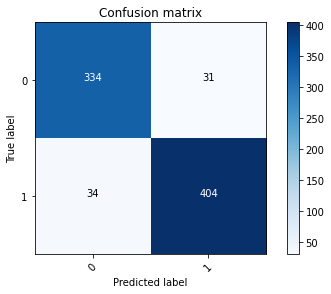

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      yhat = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if yhat.shape[1] == 64:
          yhat = np.hstack((yhat, yhat, yhat, yhat, yhat, yhat, yhat, yhat))
      elif yhat.shape[1] == 128:
          yhat = np.hstack((yhat, yhat, yhat, yhat))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = SVC()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members=[{'model': intermediate_layer_model1, 'preprocess': scratch_preprocessing}, 
         {'model': intermediate_layer_model2, 'preprocess': scratch_preprocessing},
         {'model': intermediate_layer_model3, 'preprocess': inception_preprocess}]

# fit stacked model using the ensemble
ensemble6 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble6, os.path.join(MODEL_PATH, 'svc_pretrained_layers.h5'))

train_yhat = stacked_prediction(members, ensemble6, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_yhat))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble6 on test set
yhat = stacked_prediction(members, ensemble6, test_images)
acc = accuracy_score(test_labels, np.rint(yhat))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(yhat))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_yhat = stacked_prediction(members, ensemble6, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_yhat))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_yhat))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

## Error Analysis

Number of test images: 336
Mispredictions: 31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


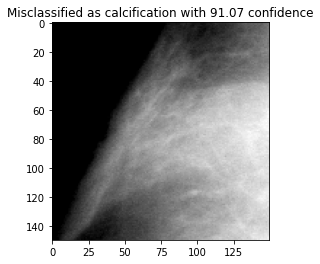

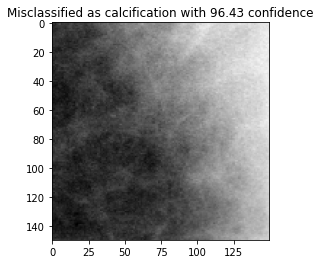

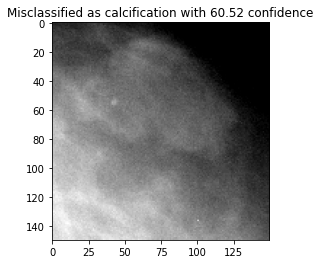

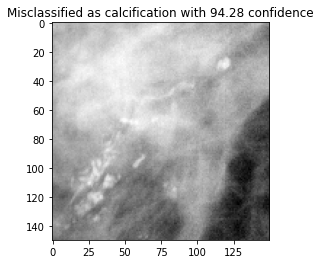

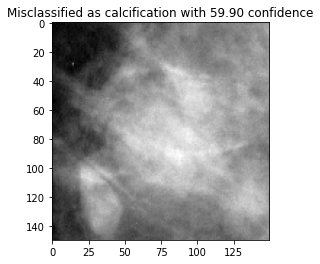

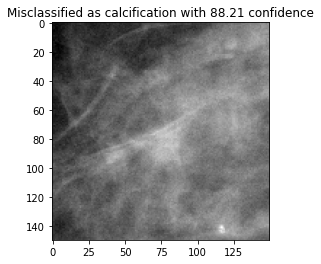

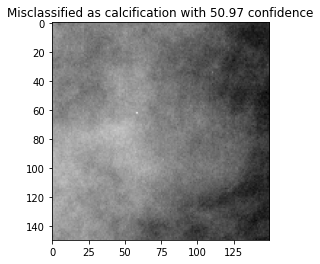

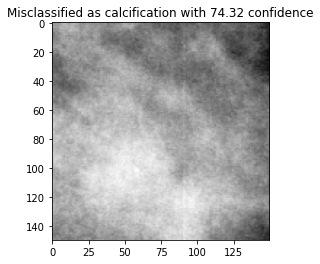

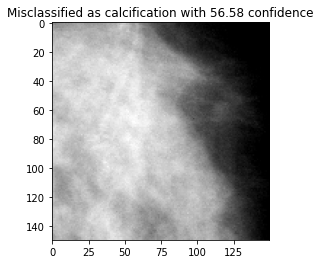

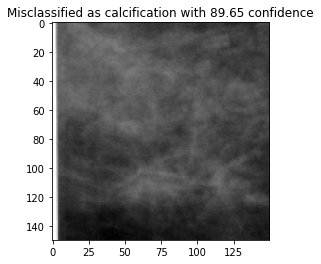

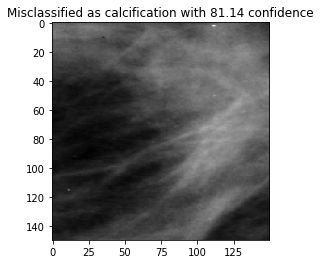

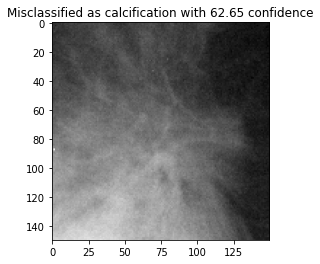

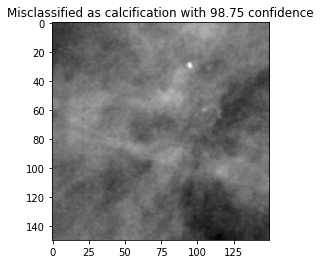

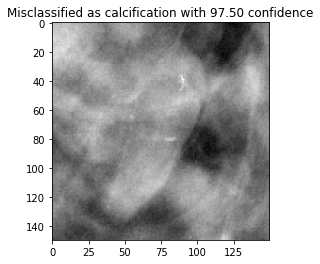

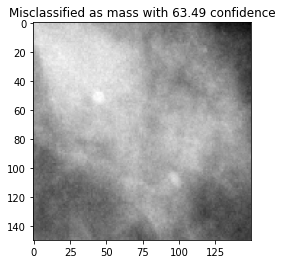

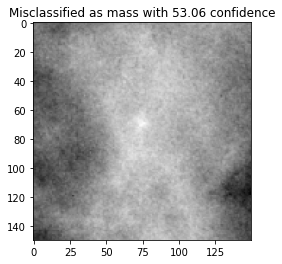

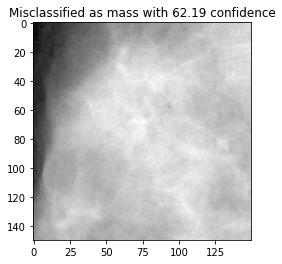

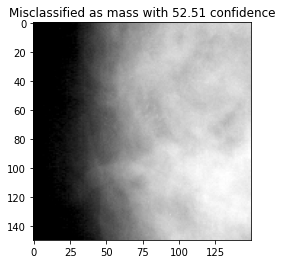

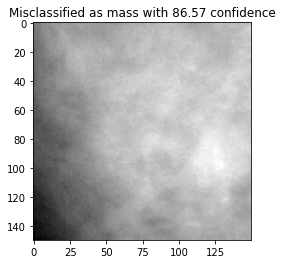

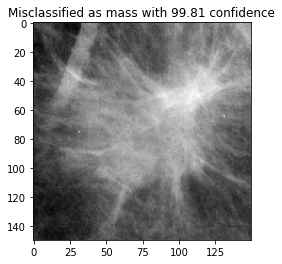

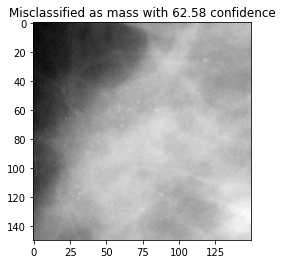

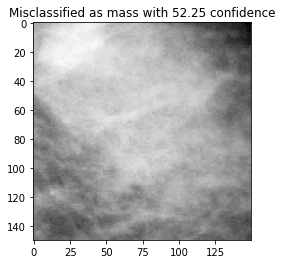

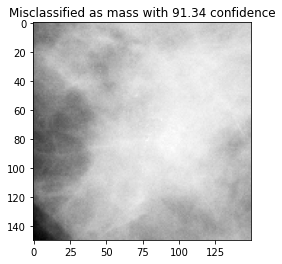

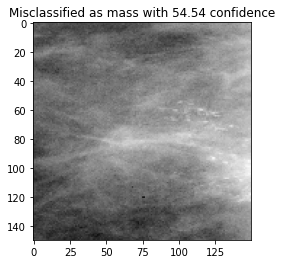

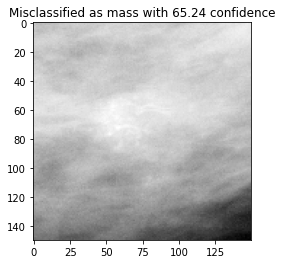

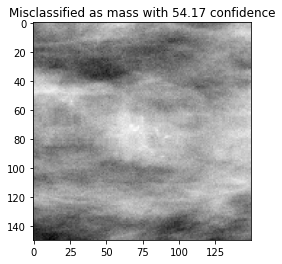

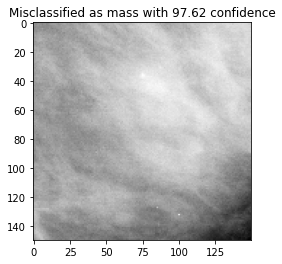

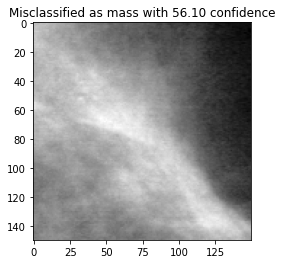

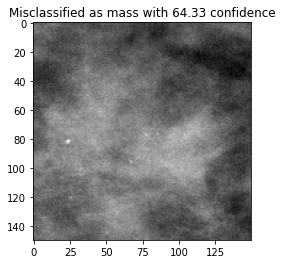

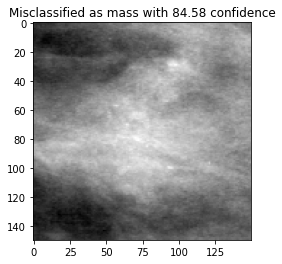

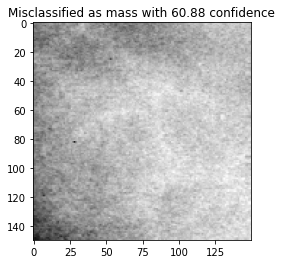

In [13]:
import seaborn as sns

def get_errors(pred):
    errors = []
    mispred = []

    for l, p, img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))

    return errors, mispred

def show_error_stats(errors, mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))

    for l,p,img in mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==1 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        #plt.axis('off')
        

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model['model'].predict(model['preprocess'](inputX), verbose=0)
      if pred.shape[1] == 64:
          pred = np.hstack((pred, pred, pred, pred, pred, pred, pred, pred))
      elif pred.shape[1] == 128:
          pred = np.hstack((pred, pred, pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

model = models.load_model(os.path.join(MODEL_PATH, 'model2_pretrained_best.h5'))
model1 = models.load_model(os.path.join(MODEL_PATH, 'model10_pretrained_layers.h5'))
model2 = models.load_model(os.path.join(MODEL_PATH, 'model9_pretrained_layers.h5'))
model3 = models.load_model(os.path.join(MODEL_PATH, 'inception_layers.h5'))

members=[{'model': model1, 'preprocess': scratch_preprocessing}, 
         {'model': model2, 'preprocess': scratch_preprocessing},
         {'model': model3, 'preprocess': inception_preprocess}]

test_pred = stacked_prediction(members, model, test_images)
errors, mispred = get_errors(test_pred)
show_error_stats(errors, mispred)